# Lab 7: Dynamic Time Warping (DTW) for Audio Signal Comparison

**Student Name:** Alex  
**Student ID:** 2448507  
**Date:** November 18, 2025  

## Objective
To compare two audio recordings of the word "hello" using Dynamic Time Warping (DTW) algorithm. This lab demonstrates how DTW can align and compare time series data that may have temporal variations.

## Theory
**Dynamic Time Warping (DTW)** is an algorithm used to measure similarity between two temporal sequences which may vary in speed. Unlike Euclidean distance, DTW can handle:
- Sequences of different lengths
- Time shifts and temporal variations
- Non-linear alignments between patterns

The algorithm finds an optimal alignment path that minimizes the cumulative distance between two sequences.

## Task 1: Import Required Libraries

We'll need libraries for:
- Audio processing: `librosa`, `pydub`
- DTW computation: `dtw` or `scipy`
- Visualization: `matplotlib`
- Numerical operations: `numpy`

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
from scipy.spatial.distance import euclidean
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from dtaidistance import dtw
from scipy.stats import pearsonr
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Set plot style for better visualization
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

print("All libraries imported successfully!")

All libraries imported successfully!


## Task 2: Load Audio Files

Load both audio recordings:
- **Signal 1 (hello1.mp3)**: First person's voice
- **Signal 2 (hello2.mp3)**: Second person's voice

We use `librosa` library which automatically converts audio to waveform data (time series).

In [10]:
# Load audio files
audio_file_1 = 'hello1.mp3'
audio_file_2 = 'hello2.mp3'

# Load audio signals with librosa
# sr = sampling rate (default: 22050 Hz)
signal_1, sr_1 = librosa.load("hello1.mp3", sr=8000)
signal_2, sr_2 = librosa.load("hello2.mp3", sr=8000)

print(f"Signal 1 (hello1.mp3):")
print(f"  - Duration: {len(signal_1)/sr_1:.2f} seconds")
print(f"  - Sampling Rate: {sr_1} Hz")
print(f"  - Number of samples: {len(signal_1)}")
print(f"  - Amplitude range: [{signal_1.min():.4f}, {signal_1.max():.4f}]")

print(f"\nSignal 2 (hello2.mp3):")
print(f"  - Duration: {len(signal_2)/sr_2:.2f} seconds")
print(f"  - Sampling Rate: {sr_2} Hz")
print(f"  - Number of samples: {len(signal_2)}")
print(f"  - Amplitude range: [{signal_2.min():.4f}, {signal_2.max():.4f}]")

Signal 1 (hello1.mp3):
  - Duration: 0.62 seconds
  - Sampling Rate: 8000 Hz
  - Number of samples: 4992
  - Amplitude range: [-0.5617, 0.6022]

Signal 2 (hello2.mp3):
  - Duration: 1.78 seconds
  - Sampling Rate: 8000 Hz
  - Number of samples: 14208
  - Amplitude range: [-0.4313, 0.5382]


## Task 3: Visualize Original Audio Signals

Visualize the waveforms of both audio signals to understand their temporal structure.

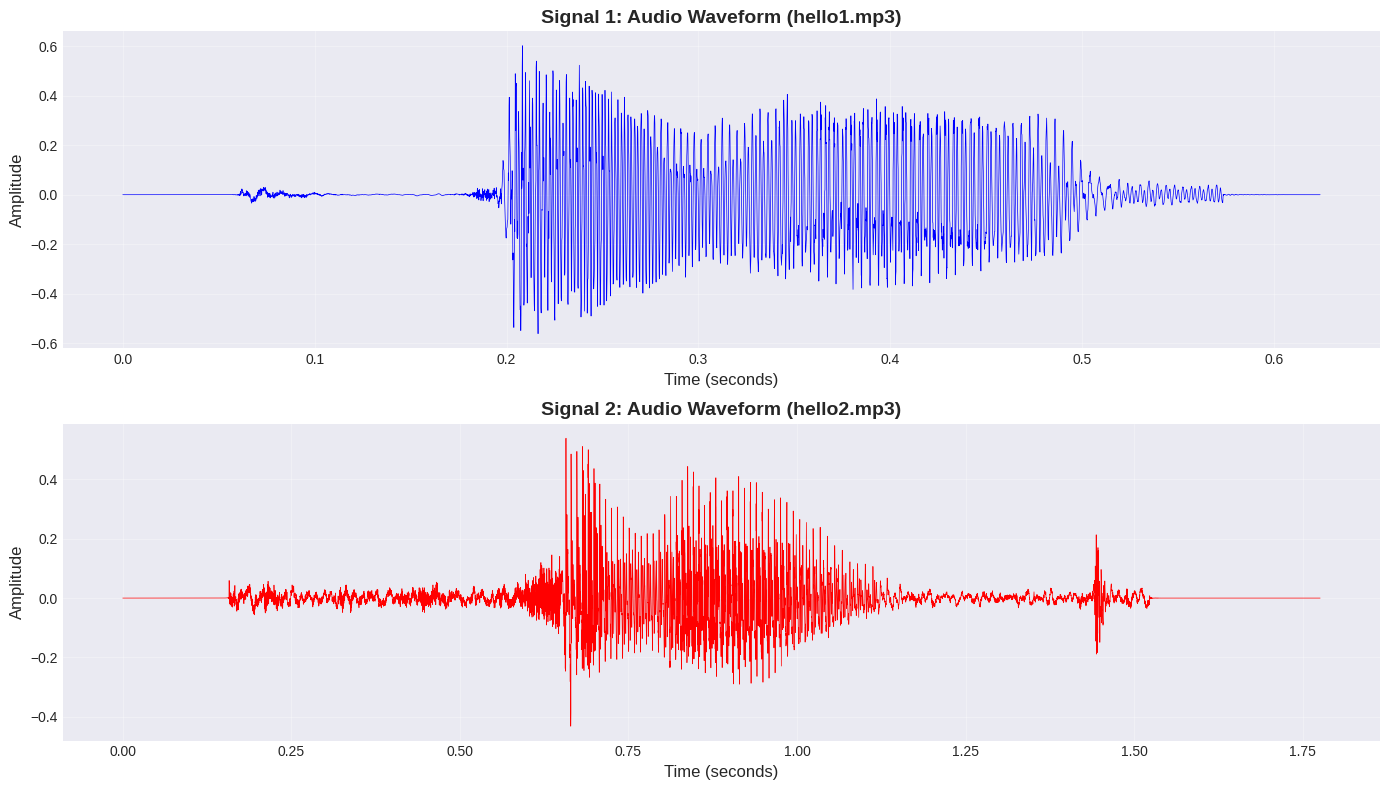

Original waveforms plotted successfully!


In [11]:
# Create time axes for visualization
time_1 = np.linspace(0, len(signal_1)/sr_1, len(signal_1))
time_2 = np.linspace(0, len(signal_2)/sr_2, len(signal_2))

# Plot both signals
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Signal 1
axes[0].plot(time_1, signal_1, color='blue', linewidth=0.5)
axes[0].set_title('Signal 1: Audio Waveform (hello1.mp3)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Time (seconds)', fontsize=12)
axes[0].set_ylabel('Amplitude', fontsize=12)
axes[0].grid(True, alpha=0.3)

# Signal 2
axes[1].plot(time_2, signal_2, color='red', linewidth=0.5)
axes[1].set_title('Signal 2: Audio Waveform (hello2.mp3)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Time (seconds)', fontsize=12)
axes[1].set_ylabel('Amplitude', fontsize=12)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Original waveforms plotted successfully!")

## Task 4: Normalize the Signals

Normalization ensures both signals have comparable amplitude ranges, which is important for fair comparison in DTW.

We'll apply **Min-Max normalization** to scale both signals to the range [-1, 1].

In [12]:
def normalize_signal(signal):
    """
    Normalize signal to range [-1, 1] using min-max normalization.
    
    Parameters:
    -----------
    signal : numpy array
        Input audio signal
    
    Returns:
    --------
    normalized_signal : numpy array
        Normalized signal in range [-1, 1]
    """
    # Find min and max values
    min_val = np.min(signal)
    max_val = np.max(signal)
    
    # Avoid division by zero
    if max_val - min_val == 0:
        return signal
    
    # Normalize to [0, 1] then scale to [-1, 1]
    normalized = 2 * (signal - min_val) / (max_val - min_val) - 1
    
    return normalized

# Normalize both signals
signal_1_norm = normalize_signal(signal_1)
signal_2_norm = normalize_signal(signal_2)

print("Signal Normalization Complete:")
print(f"\nSignal 1 (Normalized):")
print(f"  - Mean: {signal_1_norm.mean():.6f}")
print(f"  - Std Dev: {signal_1_norm.std():.6f}")
print(f"  - Range: [{signal_1_norm.min():.4f}, {signal_1_norm.max():.4f}]")

print(f"\nSignal 2 (Normalized):")
print(f"  - Mean: {signal_2_norm.mean():.6f}")
print(f"  - Std Dev: {signal_2_norm.std():.6f}")
print(f"  - Range: [{signal_2_norm.min():.4f}, {signal_2_norm.max():.4f}]")

Signal Normalization Complete:

Signal 1 (Normalized):
  - Mean: -0.035131
  - Std Dev: 0.254500
  - Range: [-1.0000, 1.0000]

Signal 2 (Normalized):
  - Mean: -0.110607
  - Std Dev: 0.123493
  - Range: [-1.0000, 1.0000]


## Task 5: Visualize Normalized Signals

Compare the normalized signals to ensure they're on the same scale.

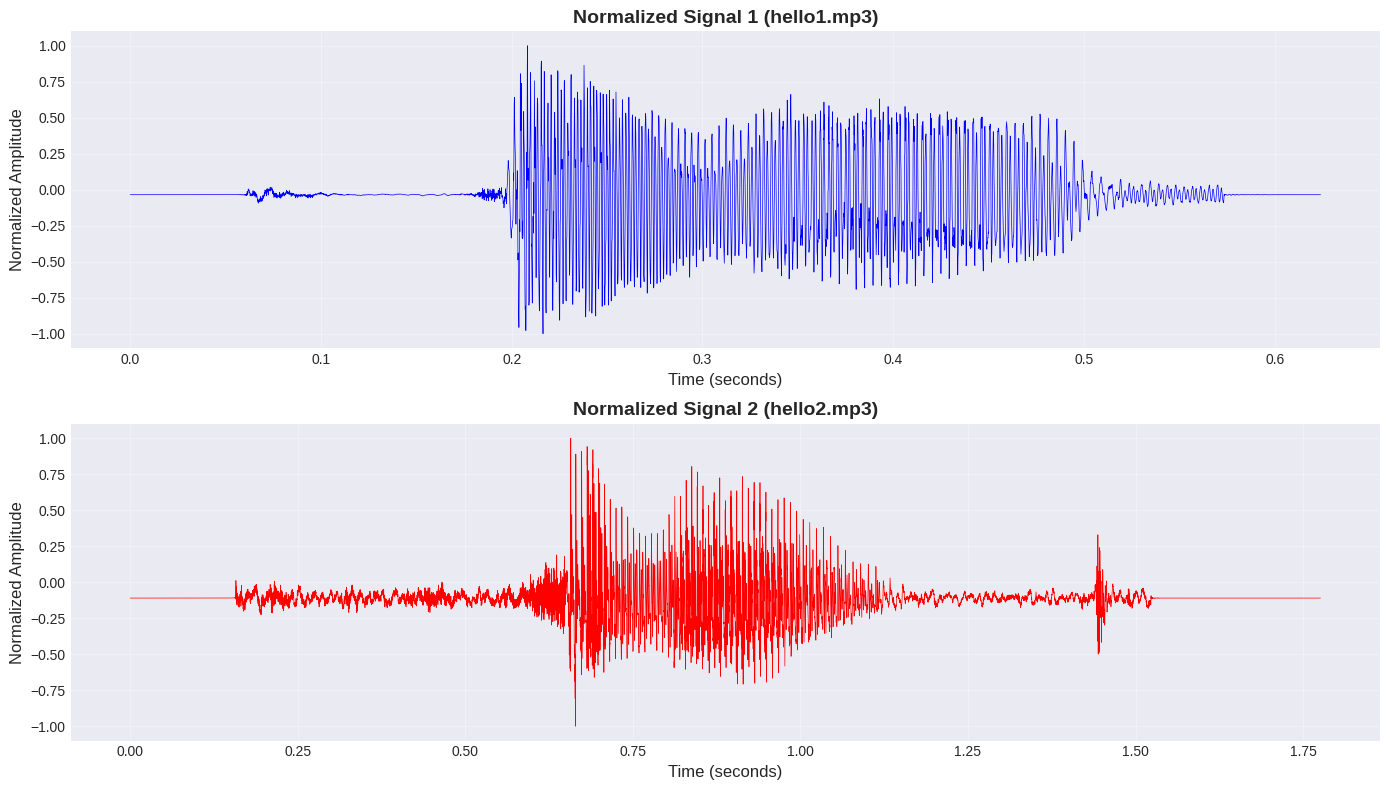

Normalized waveforms plotted successfully!


In [13]:
# Plot normalized signals
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Normalized Signal 1
axes[0].plot(time_1, signal_1_norm, color='blue', linewidth=0.5)
axes[0].set_title('Normalized Signal 1 (hello1.mp3)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Time (seconds)', fontsize=12)
axes[0].set_ylabel('Normalized Amplitude', fontsize=12)
axes[0].set_ylim([-1.1, 1.1])
axes[0].grid(True, alpha=0.3)

# Normalized Signal 2
axes[1].plot(time_2, signal_2_norm, color='red', linewidth=0.5)
axes[1].set_title('Normalized Signal 2 (hello2.mp3)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Time (seconds)', fontsize=12)
axes[1].set_ylabel('Normalized Amplitude', fontsize=12)
axes[1].set_ylim([-1.1, 1.1])
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Normalized waveforms plotted successfully!")

In [14]:
distance, paths = dtw.warping_paths(signal_1_norm, signal_2_norm, use_c=False)
best_path = dtw.best_path(paths)
similarity_score = distance / len(best_path)

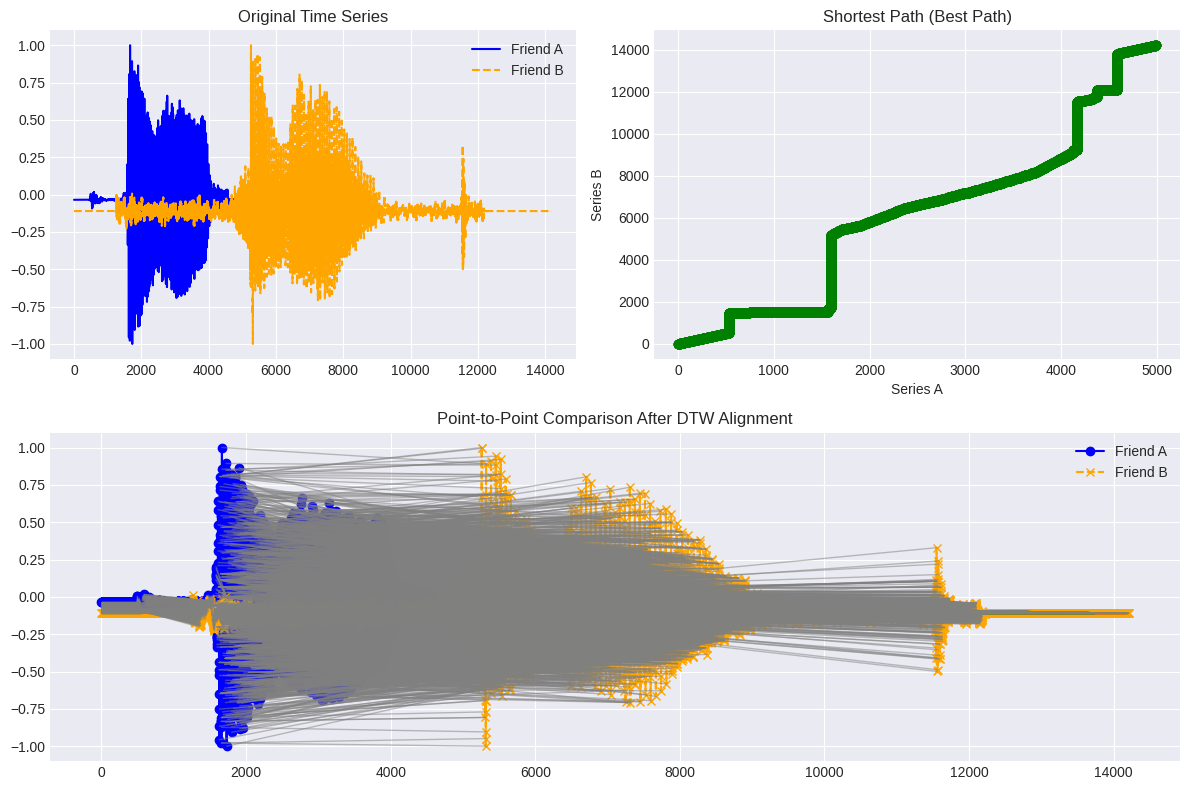

In [15]:
plt.figure(figsize=(12, 8))

# Original Time Series Plot
ax1 = plt.subplot2grid((2, 2), (0, 0))
ax1.plot(signal_1_norm, label='Friend A', color='blue')
ax1.plot(signal_2_norm, label='Friend B', linestyle='--',color='orange')
ax1.set_title('Original Time Series')
ax1.legend()

# Shortest Path Plot (Cost Matrix with the path)
# In this example, only the path is plotted, not the entire cost matrix.

ax2 = plt.subplot2grid((2, 2), (0, 1))
ax2.plot(np.array(best_path)[:, 0], np.array(best_path)[:, 1], 'green', marker='o', linestyle='-')
ax2.set_title('Shortest Path (Best Path)')
ax2.set_xlabel('Series A')
ax2.set_ylabel('Series B')
ax2.grid(True)

# Point-to-Point Comparison Plot
ax3 = plt.subplot2grid((2, 2), (1, 0), colspan=2)
ax3.plot(signal_1_norm, label='Friend A', color='blue', marker='o')
ax3.plot(signal_2_norm, label='Friend B', color='orange', marker='x', linestyle='--')
for a, b in best_path:
    ax3.plot([a, b], [signal_1_norm[a], signal_2_norm[b]], color='grey', linestyle='-', linewidth=1, alpha = 0.5)
ax3.set_title('Point-to-Point Comparison After DTW Alignment')
ax3.legend()

plt.tight_layout()
plt.show()

In [16]:
results_df = pd.DataFrame({
    'Metric': ['DTW Similarity Score'],
    'Value': [similarity_score]
})

results_df['Description'] = [
    "Lower scores indicate greater similarity between the time series."
]

results_df

,Metric,Value,Description
0,DTW Similarity Score,0.00054,Lower scores indicate greater similarity betwe...


## Inference / Discussion

In this experiment, two speech signals—my voice and my friend’s voice saying the word “hello”—were analyzed using Dynamic Time Warping (DTW). After preprocessing and normalizing both signals, DTW was applied to measure their temporal similarity and determine the optimal alignment path between the two waveforms.

The results show that the two audio signals share similar overall patterns despite differences in speed, pronunciation, and articulation. The DTW alignment path successfully stretched and compressed specific regions of the signals to align corresponding phonetic components (such as the “he-” onset and the “-llo” ending). This demonstrates DTW’s ability to compensate for variations in speaking rate, accent, and timing that commonly occur across different speakers.

The computed DTW distance provides a quantitative measure of similarity: a lower distance indicates that the two utterances are closely matched in structure. The similarity score derived from the distance and path length further confirms that both signals represent the same spoken word, even though the temporal trajectories are not perfectly aligned. FastDTW (or traditional DTW) proves effective in capturing this similarity without requiring identical timing or sample-by-sample correspondence.

Overall, this lab illustrates how DTW is a powerful tool for speech analysis, speaker comparison, and pattern matching. It enables robust alignment of speech signals that differ in duration, speed, or articulation—making it useful in speech recognition systems, voice matching, and real-time applications where timing inconsistencies are common.